In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# from umap.umap_ import UMAP
# from sklearn.cluster import KMeans
# from sklearn.cluster import HDBSCAN
from kmodes.kmodes import KModes
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../strabospot_data.csv")

/var/folders/k_/qdqmhtsx7mz24yl5hmlfnjz80000gn/T/ipykernel_60242/2931195543.py:1: DtypeWarning: Columns (11,12,15,16,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,

In [3]:
def val_count(data):
    #use this to see value counts of each column
    counter = 0
    for i in data.columns:
        print(counter)
        print(data[i].value_counts())
        counter += 1
        print("=========================="*5)
    print(data.shape)

In [4]:
val_count(df)

0
contacts drawing
b              15187
c              13368
d              10222
a-              9350
a               6884
b+              3371
c-              2427
b-              2350
c+              1440
f                859
0.300110724        1
742408             1
Name: count, dtype: int64
1
contacts drawing quality
c                      15109
a-                     11981
b                      11583
d                       9643
a                       6551
c-                      4585
b+                      3142
c+                      1627
b-                      1237
 38.56437533444736]        1
 38.49801201400001]        1
Name: count, dtype: int64
2
classification of spots
b                       17848
c                       16258
a                        7757
b+                       5814
a-                       5514
d                        3693
b-                       2795
c-                       2707
c+                       2511
d+                        561
 [-10

In [5]:
df = df.drop(columns= df.columns[153:].tolist(), axis = 1) #dropped because features were unamed and VERY sparse
df = df.drop_duplicates()
df = df.drop([46341,40941]) #outliers
df["Complete"] = df["Complete"].replace("TRUE", True )
df["Complete"] = df["Complete"].replace("FALSE", False )
df["properties_trace_trace_feature"] = df["properties_trace_trace_feature"].replace("TRUE", True )
df["properties_inferences_outcrop_in_place"] = df["properties_inferences_outcrop_in_place"].replace("5 - definitely in place", 5 )
df["properties_symbology_lineWidth"] = df["properties_symbology_lineWidth"].replace(2.0,"2")
df["properties_symbology_lineWidth"] = df["properties_symbology_lineWidth"].replace(4.0,"4")
# df['properties_image_basemap'] = df["properties_symbology_lineWidth"].replace(pd.NA,np.nan) 
df = df.dropna(axis=1, how= "all")
# df = df.dropna(axis = 1, thresh = 100)/



df_copy = df.copy()
df.shape



/var/folders/k_/qdqmhtsx7mz24yl5hmlfnjz80000gn/T/ipykernel_60242/4069648855.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["properties_inferences_outcrop_in_place"] = df["properties_inferences_outcrop_in_place"].replace("5 - definitely in place", 5 )


(46852, 118)

In [6]:
val_count(df)

0
contacts drawing
b     10732
c      8898
a-     8189
a      5400
d      4779
c-     2427
b-     2182
b+     1946
c+     1440
f       859
Name: count, dtype: int64
1
contacts drawing quality
a-    10208
c      9033
b      7968
d      5662
a      4872
c-     3682
b+     2563
c+     1627
b-     1237
Name: count, dtype: int64
2
classification of spots
b     14481
c      8382
a      6430
b+     5325
a-     4953
b-     2402
c+     1968
d      1509
c-     1234
d+      168
Name: count, dtype: int64
3
correctness of spots
b     12884
c     10137
a      8750
a-     6257
d      3212
c-     2089
b+     1646
b-     1453
c+      424
Name: count, dtype: int64
4
completeness of map
a     13886
b     10275
a-     8233
c      5763
d      2519
c-     2005
b+     1759
f       859
c+      812
b-      620
d+      121
Name: count, dtype: int64
5
unit labels
a     27667
b      5458
c      5089
a-     3007
d      2749
b+     1751
c-      562
c+      374
b-      131
d+       64
Name: count, dtype: int64
6
ima

In [7]:
def binary_simplification(df, unique_threshold=100):
    # Data that has a lot of unique values does not really mean much because almost everythin is unqique or doesn't have some majority. Used this function to convert categorical data and sparse numerical to binary for just presence instead
    df_new = df.copy()
    binary_col_data = {}
    columns_to_drop = []
    categorical_features = []

    # Identifies what features are not numeric
    for col in df_new.columns: 
        
        categorical_features.append(col) #this is only to be used to turn EVERYTHING to binary
      
      
      #UNCOMMENT below to just simplify ONLY categorical and  data where there is a lot of unique features
        # try:
        #     df_new[col] = pd.to_numeric(df_new[col])
        # except:
        #      categorical_features.append(col)

    for col in categorical_features:
        series = df_new[col].replace('', np.nan).dropna() 
        unique_count = series.nunique()
        majority_count = series.value_counts().iloc[0]
        
        
        #USE the commented if statement to ONLY simplify categorical and sparse data
        # if unique_count > unique_threshold or majority_count < 10:
        
        # ["contacts drawing", "contacts drawing quality", "classification of spots" , "correctness of spots", "completeness of map","unit labels",  "images", "overall impression", "Complete"]:
        if col not in ['Complete']: #this just converts EVERYTHING to binary, change later if needed (use the list in the line directly above)
            print(f"Converting {col} to binary")
            
            # 1 if present (not NaN/empty string), 0 otherwise
            binary_col_data[col] = df_new[col].replace('', np.nan).notna().astype(int)
            columns_to_drop.append(col)
            

    df_new = df_new.drop(columns=columns_to_drop)
    
    # Add all new binary columns in one go using pd.concat
    if binary_col_data:
        df_new = pd.concat([df_new, pd.DataFrame(binary_col_data, index=df_new.index)], axis=1)
        
    print(f"Number of Categorical: {len(categorical_features)}")
    return df_new

In [8]:
df = binary_simplification(df)
val_count(df)
df['Complete'] = df['Complete'].replace(True, 1)
df['Complete'] = df['Complete'].replace(False, 0)

# df["Complete"] = df["Complete"].astype(int)
df["Complete"].value_counts()

Converting contacts drawing to binary
Converting contacts drawing quality to binary
Converting classification of spots to binary
Converting correctness of spots to binary
Converting completeness of map to binary
Converting unit labels to binary
Converting images to binary
Converting overall impression to binary
Converting geometry_type to binary
Converting geometry_coordinates to binary
Converting properties_date to binary
Converting properties_trace_trace_feature to binary
Converting properties_trace_trace_type to binary
Converting properties_name to binary
Converting properties_time to binary
Converting properties_id to binary
Converting properties_modified_timestamp to binary
Converting properties_self to binary
Converting type to binary
Converting properties_images to binary
Converting properties_images_notes to binary
Converting properties_trace_contact_type to binary
Converting properties_trace_trace_notes to binary
Converting properties_trace_geologic_structure_type to binary
Co

/var/folders/k_/qdqmhtsx7mz24yl5hmlfnjz80000gn/T/ipykernel_60242/4009998106.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Complete'] = df['Complete'].replace(False, 0)


Complete
1.0    33997
0.0    12853
Name: count, dtype: int64

In [9]:
data_to_encode = []
def OHE(df):
    #use this function to find the categorical data to use OHE on
    #it just takes top 10 values of categorical data, no point in creating hundreds of new and sparse features
    global data_to_encode
    
    data_to_encode = []
    for col in df.columns:
        print(col)
        vc = df[col].value_counts(dropna = False)
        vc_len = len(vc)
        
        
        
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            
            if vc_len > 11 and vc.iloc[0] > 1:
                if df[col].dtypes == object:
                    top_categories = vc.nlargest(10).index.tolist()
                    df[col] = df[col].apply(lambda x: x if x in top_categories else "")
                else:
                    top_categories = vc.nlargest(10).index.tolist()
                    df[col] = df[col].apply(lambda x: x if x in top_categories else np.nan)
                    
            data_to_encode.append(col)

    #GET rid of this, DO NOT replace values of data_to_encode. For now, just using to test purely binary data
    data_to_encode = ["contacts drawing", "contacts drawing quality", "classification of spots" , "correctness of spots", "completeness of map","unit labels",  "images", "overall impression"]
    
    
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    df_to_encode = df[data_to_encode].astype(str).replace(['nan', '', "NaN"], 'OTHER_OR_REDUCED')
    encoded_features = onehot_encoder.fit_transform(df_to_encode)
    encoded_df = pd.DataFrame( 
        encoded_features, 
        columns=onehot_encoder.get_feature_names_out(data_to_encode),
        index=df.index 
    )
    
    df = df.drop(data_to_encode, axis = 1)
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    df.columns = [col.replace('\n', '_') for col in df.columns]
    
    return df




In [10]:
# df = OHE(df)
# df.drop("Complete", axis=1)
val_count(df)
df = df.fillna(0)
df["Complete"].value_counts()

0
Complete
1.0    33997
0.0    12853
Name: count, dtype: int64
1
contacts drawing
1    46852
Name: count, dtype: int64
2
contacts drawing quality
1    46852
Name: count, dtype: int64
3
classification of spots
1    46852
Name: count, dtype: int64
4
correctness of spots
1    46852
Name: count, dtype: int64
5
completeness of map
1    46852
Name: count, dtype: int64
6
unit labels
1    46852
Name: count, dtype: int64
7
images
1    46852
Name: count, dtype: int64
8
overall impression
1    46852
Name: count, dtype: int64
9
geometry_type
1    46852
Name: count, dtype: int64
10
geometry_coordinates
1    46852
Name: count, dtype: int64
11
properties_date
1    46850
0        2
Name: count, dtype: int64
12
properties_trace_trace_feature
0    41863
1     4989
Name: count, dtype: int64
13
properties_trace_trace_type
0    41863
1     4989
Name: count, dtype: int64
14
properties_name
1    46623
0      229
Name: count, dtype: int64
15
properties_time
1    46850
0        2
Name: count, dtype: int64
16
p

Complete
1.0    33997
0.0    12855
Name: count, dtype: int64

In [11]:
#USE this cell to find optimal number of PCs with PCA

def optimal_PC(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data)
    # val_count(scaled_data)

    pca = PCA(n_components= len(scaled_data.columns))
    pca.fit(scaled_data)


    plt.ylabel("Eigenvalue")
    plt.xlabel("Number of Features")
    plt.title("PCA Eigenvalues")
    plt.ylim(0,max(pca.explained_variance_))
    plt.xlim(0,20)
    # plt.style.context("seaborn-whitegrid")
    # plt.axhline(y=1,color = "r", lineystyle = "--")
    plt.plot(pca.explained_variance_, "o-")
    plt.show


In [12]:
# optimal_PC(df)

In [13]:
def runPCA(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df) #scaling to prepare for PCA

    pca =PCA(n_components= 0.9) #reduces down to only have 8 features
    principal_components = pca.fit_transform(scaled_data)
    pca_df = pd.DataFrame(data = principal_components)
    weights = pca.components_

    return pca_df, weights
    


In [14]:
# pca_data, pc_weights = runPCA(df)
# val_count(pca_data)

In [15]:
def visualize_UMAP(df, clustered):
    #pass in dataframe you want to visualize with umap and whether or not it has been clustered
    reducer = UMAP(random_state=42)

    if not clustered:
        embedding = reducer.fit_transform(df)
        plt.figure(figsize=(8, 8))
        scatter = plt.scatter(
            embedding[:, 0], #x-axis
            embedding[:, 1], #y-axis
            s=2,       # adjusts point size
            alpha = 0.3,
            color = "k"
        )
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        embedding = reducer.fit_transform(df.drop(columns= "cluster"))
        scatter = plt.scatter(
            embedding[:, 0], #x-axis
            embedding[:, 1], #y-axis
            s=2,       # changes the size of each dot
            label='Cluster Label',
            c=df["cluster"], # Uses the values to color each dot
            cmap = "viridis"
        )
        colorbar = plt.colorbar(scatter)
        colorbar.set_label('Cluster ID')

In [16]:
# visualize_UMAP(df, False)

In [17]:
# Uses ordinal encoding for features with grade scores ex. contacts drawing

# from sklearn.preprocessing import OrdinalEncoder
# encoder = OrdinalEncoder(categories= ["a+","a","a-", "b+","b", "b-", "c+","c", "c-", "d+","d", "d-", "f"])


# grade_mapping = {
#     'a+': 0, 'a': 1, 'a-': 2,
#     'b+': 3, 'b': 4, 'b-': 5,
#     'c+': 6, 'c': 7, 'c-': 8,
#     'd+': 9, 'd': 10, 'd-': 11,
#     'f': 12  
# }

# for col in ["contacts drawing", "contacts drawing quality", "classification of spots" , "correctness of spots", "completeness of map","unit labels",  "images", "overall impression"]:
#     df[col] = df[col].map(grade_mapping)
    


val_count(df)

0
Complete
1.0    33997
0.0    12855
Name: count, dtype: int64
1
contacts drawing
1    46852
Name: count, dtype: int64
2
contacts drawing quality
1    46852
Name: count, dtype: int64
3
classification of spots
1    46852
Name: count, dtype: int64
4
correctness of spots
1    46852
Name: count, dtype: int64
5
completeness of map
1    46852
Name: count, dtype: int64
6
unit labels
1    46852
Name: count, dtype: int64
7
images
1    46852
Name: count, dtype: int64
8
overall impression
1    46852
Name: count, dtype: int64
9
geometry_type
1    46852
Name: count, dtype: int64
10
geometry_coordinates
1    46852
Name: count, dtype: int64
11
properties_date
1    46850
0        2
Name: count, dtype: int64
12
properties_trace_trace_feature
0    41863
1     4989
Name: count, dtype: int64
13
properties_trace_trace_type
0    41863
1     4989
Name: count, dtype: int64
14
properties_name
1    46623
0      229
Name: count, dtype: int64
15
properties_time
1    46850
0        2
Name: count, dtype: int64
16
p

In [18]:
# uses variance threshold for feature reduction => removes features where all values are the same

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0) #removes all features with low variance in 100% of samples  (you do (1 - percentage of save values) * percentage of vaues that are the same)
selector.fit_transform(df)

cols_idxs = selector.get_support(indices=True)
df = df.iloc[:,cols_idxs]


# df = df.drop("Complete", axis=1)

val_count(df)

0
Complete
1.0    33997
0.0    12855
Name: count, dtype: int64
1
properties_date
1    46850
0        2
Name: count, dtype: int64
2
properties_trace_trace_feature
0    41863
1     4989
Name: count, dtype: int64
3
properties_trace_trace_type
0    41863
1     4989
Name: count, dtype: int64
4
properties_name
1    46623
0      229
Name: count, dtype: int64
5
properties_time
1    46850
0        2
Name: count, dtype: int64
6
properties_id
1    46850
0        2
Name: count, dtype: int64
7
properties_modified_timestamp
1    46850
0        2
Name: count, dtype: int64
8
properties_self
1    46850
0        2
Name: count, dtype: int64
9
type
1    46850
0        2
Name: count, dtype: int64
10
properties_images
0    41871
1     4981
Name: count, dtype: int64
11
properties_images_notes
0    46636
1      216
Name: count, dtype: int64
12
properties_trace_contact_type
0    44796
1     2056
Name: count, dtype: int64
13
properties_trace_trace_notes
0    46773
1       79
Name: count, dtype: int64
14
propert

In [19]:
#implementing SelectKBest for feature reduction

# selector = SelectKBest(f_classif, k=50)
# selector.fit_transform(df)

# cols_idxs = selector.get_support(indices=True)
# df = df.iloc[:,cols_idxs]

# val_count(df)


(46852, 108)
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 144791.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 144791.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 144791.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 144791.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15514, cost: 118557.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7173, cost: 118353.0
Run 2, iteration: 2/100, moves: 0, cost: 118353.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 4110, cost: 1113

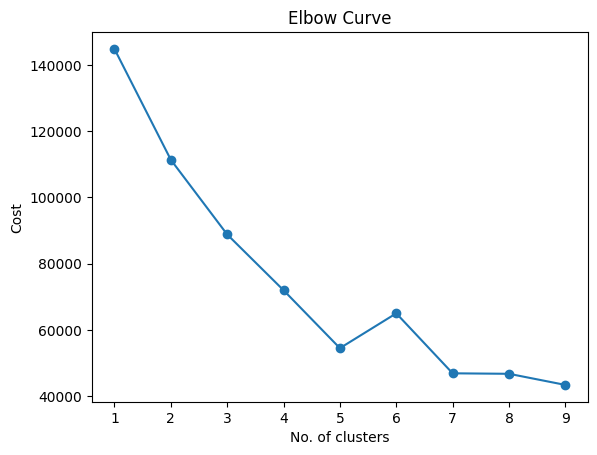

NameError: name 'gfchgjhkjl' is not defined

In [20]:
# Use this cell to find optimal k value for KMODES with an elbow curve

print(df.shape)
cost = []
K = range(1,10)
for k in list(K):
    kmode = KModes(n_clusters=k, init = "Huang", n_init = 4, verbose=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'o-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

gfchgjhkjl


In [ ]:
# Use this cell to find optimal k value for KMODES with a Calinski-Harabasz Index curve


# print(df.shape)
# results = {}
# K = range(2,10)
# for k in list(K):
#     kmode = KModes(n_clusters=k, init = "random", n_init = 4, verbose=1)
#     clusters = kmode.fit_predict(df)
#     db_index = calinski_harabasz_score(df, clusters)    
#     results[k] = db_index
    

# plt.plot(list(results.keys()), list(results.values()))
# plt.xlabel("Number of clusters")
# plt.ylabel("Calinski-Harabasz Index")
# plt.show()



(46852, 108)
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 205, cost: 121675.0
Run 1, iteration: 2/100, moves: 634, cost: 121675.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 145, cost: 112823.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 4962, cost: 112823.0
Run 3, iteration: 2/100, moves: 0, cost: 112823.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1451, cost: 114763.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10668, cost: 88822.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 849, cost: 93846.0
Init: initializing centroids
Init: initializing clusters
Starting ite

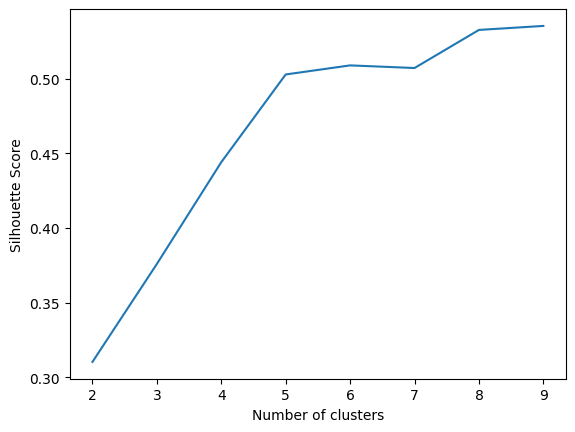

NameError: name 'cfhgvjhbkjnlkm' is not defined

In [ ]:
# Use this cell to find optimal k value for KMODES with a Silhouette Score curve


# print(df.shape)
# results = {}
# K = range(2,10)
# for k in list(K):
#     kmode = KModes(n_clusters=k, init = "Huang", n_init = 4, verbose=1) #Make sure to change the n_init argument as needed
#     clusters = kmode.fit_predict(df)
#     db_index = silhouette_score(df, clusters, metric= "hamming")    
#     results[k] = db_index
    

# plt.plot(list(results.keys()), list(results.values()))
# plt.xlabel("Number of clusters")
# plt.ylabel("Silhouette Score")
# plt.show()

# cfhgvjhbkjnlkm;l


In [21]:
# print(df.shape)
# df = df.dropna()
# print(df.shape)

km = KModes(n_clusters= 7, init = "Huang" , n_init= 20).fit(df)
#use 7 for when you use Complete as feature
#use 6 for when you DON'T use Complete as feature

In [22]:
from scipy.stats import chi2_contingency
def chi_test(ds,labels):
    ct = pd.crosstab(ds,labels)    
    return chi2_contingency(ct)

res = df.apply(lambda x:chi_test(x,km.labels_)[:-1]).T
res.columns = ["chi2","p","df"]
print(res.sort_values("p").to_string())


                                                                 chi2              p   df
Complete                                                 32096.623555   0.000000e+00  6.0
properties_orientation_feature_type                       2220.499965   0.000000e+00  6.0
properties_orientation_id                                 2228.372110   0.000000e+00  6.0
properties_orientation_type                               2228.372110   0.000000e+00  6.0
properties_orientation_dip                                2158.060685   0.000000e+00  6.0
properties_orientation_label                              2255.281066   0.000000e+00  6.0
properties_altitude                                      34831.268322   0.000000e+00  6.0
properties_viewed_timestamp                              45307.675994   0.000000e+00  6.0
properties_orientation_strike                             2158.060685   0.000000e+00  6.0
properties_symbology_lineColor                           46777.178152   0.000000e+00  6.0
properties

In [23]:
df["cluster"] = km.labels_
df_copy["cluster"] = km.labels_
val_count(df)



0
Complete
1.0    33997
0.0    12855
Name: count, dtype: int64
1
properties_date
1    46850
0        2
Name: count, dtype: int64
2
properties_trace_trace_feature
0    41863
1     4989
Name: count, dtype: int64
3
properties_trace_trace_type
0    41863
1     4989
Name: count, dtype: int64
4
properties_name
1    46623
0      229
Name: count, dtype: int64
5
properties_time
1    46850
0        2
Name: count, dtype: int64
6
properties_id
1    46850
0        2
Name: count, dtype: int64
7
properties_modified_timestamp
1    46850
0        2
Name: count, dtype: int64
8
properties_self
1    46850
0        2
Name: count, dtype: int64
9
type
1    46850
0        2
Name: count, dtype: int64
10
properties_images
0    41871
1     4981
Name: count, dtype: int64
11
properties_images_notes
0    46636
1      216
Name: count, dtype: int64
12
properties_trace_contact_type
0    44796
1     2056
Name: count, dtype: int64
13
properties_trace_trace_notes
0    46773
1       79
Name: count, dtype: int64
14
propert

In [24]:
features = df.columns.tolist()[0:-1]
centroids = km.cluster_centroids_

for cluster in range(len(centroids)):
    print(f"\n{'='*50}")
    print(f"Cluster {cluster}")
    print(f"{'='*50}")
    
    cluster_data = df[df["cluster"] == cluster]
    print(f"Size: {len(cluster_data)} samples\n")
    
    # For each feature, show the mode and how common it is in this cluster
    feature_importance = []
    for feature_idx, feature in enumerate(features):
        mode_value = centroids[cluster][feature_idx]
        count = (cluster_data[feature] == mode_value).sum()
        prevalence = (count / len(cluster_data)) * 100
        feature_importance.append((feature, mode_value, prevalence))
    
    # Sort by how common the mode is (higher = more defining)
    feature_importance.sort(key=lambda x: x[2], reverse=True)
    
    print("Features (sorted by prevalence):")
    for feature, mode, prevalence in feature_importance:
        print(f"  {feature}: {mode} ({prevalence:.1f}%)")



Cluster 0
Size: 5388 samples

Features (sorted by prevalence):
  properties_date: 1.0 (100.0%)
  properties_trace_trace_feature: 0.0 (100.0%)
  properties_trace_trace_type: 0.0 (100.0%)
  properties_time: 1.0 (100.0%)
  properties_id: 1.0 (100.0%)
  properties_modified_timestamp: 1.0 (100.0%)
  properties_self: 1.0 (100.0%)
  type: 1.0 (100.0%)
  properties_images_notes: 0.0 (100.0%)
  properties_trace_contact_type: 0.0 (100.0%)
  properties_trace_trace_notes: 0.0 (100.0%)
  properties_trace_geologic_structure_type: 0.0 (100.0%)
  properties_trace_shear_sense: 0.0 (100.0%)
  properties_rock_unit_unit_label_abbreviation: 0.0 (100.0%)
  properties_rock_unit_map_unit_name: 0.0 (100.0%)
  properties_image_basemap: 0.0 (100.0%)
  properties_trace_depositional_contact_type: 0.0 (100.0%)
  properties_trace_other_contact_type: 0.0 (100.0%)
  properties_trace_trace_quality: 0.0 (100.0%)
  properties_symbology_circleColor: 1.0 (100.0%)
  properties_trace_metamorphic_contact_type: 0.0 (100.0%)
 

In [25]:
# Use to see what features differ between the clusters

unique_modes_features = []
for feature_idx, feature in enumerate(features):
    modes_across_clusters = [centroids[c][feature_idx] for c in range(len(centroids))]
    unique_modes = len(set(modes_across_clusters))
    if unique_modes > 1:
        unique_modes_features.append(feature)
    print(f"{feature}: {unique_modes} different values across clusters")
    for c, mode in enumerate(modes_across_clusters):
        print(f"  Cluster {c}: {mode}")


Complete: 2 different values across clusters
  Cluster 0: 1.0
  Cluster 1: 1.0
  Cluster 2: 0.0
  Cluster 3: 1.0
  Cluster 4: 0.0
  Cluster 5: 1.0
  Cluster 6: 0.0
properties_date: 1 different values across clusters
  Cluster 0: 1.0
  Cluster 1: 1.0
  Cluster 2: 1.0
  Cluster 3: 1.0
  Cluster 4: 1.0
  Cluster 5: 1.0
  Cluster 6: 1.0
properties_trace_trace_feature: 2 different values across clusters
  Cluster 0: 0.0
  Cluster 1: 0.0
  Cluster 2: 1.0
  Cluster 3: 0.0
  Cluster 4: 0.0
  Cluster 5: 0.0
  Cluster 6: 0.0
properties_trace_trace_type: 2 different values across clusters
  Cluster 0: 0.0
  Cluster 1: 0.0
  Cluster 2: 1.0
  Cluster 3: 0.0
  Cluster 4: 0.0
  Cluster 5: 0.0
  Cluster 6: 0.0
properties_name: 1 different values across clusters
  Cluster 0: 1.0
  Cluster 1: 1.0
  Cluster 2: 1.0
  Cluster 3: 1.0
  Cluster 4: 1.0
  Cluster 5: 1.0
  Cluster 6: 1.0
properties_time: 1 different values across clusters
  Cluster 0: 1.0
  Cluster 1: 1.0
  Cluster 2: 1.0
  Cluster 3: 1.0
  Clu

In [26]:
# Now print each cluster with only the differentiating features
for cluster in range(len(centroids)):
    print(f"\n{'='*50}")
    print(f"Cluster {cluster}")
    print(f"{'='*50}")
    
    cluster_data = df[df["cluster"] == cluster]
    print(f"Size: {len(cluster_data)} samples\n")
    print("Distinguishing features:")
    important_features = []
    for feature in unique_modes_features:
        feature_idx = features.index(feature)
        mode_value = centroids[cluster][feature_idx]
        count = (cluster_data[feature] == mode_value).sum()
        cluster_prevalence = (count / len(cluster_data)) * 100
        df_prevalence = (len(df[df[feature] == mode_value]) / df[feature].shape[0]) * 100 #prevalence of a value in a feature across the entre df
        print(f"  {feature}: {mode_value} ({cluster_prevalence:.1f}%) || ({df_prevalence:.1f}%)")
        
        if max(cluster_prevalence, df_prevalence) / min(cluster_prevalence, df_prevalence) >= 2:
            important_features.append((feature, mode_value, cluster_prevalence, df_prevalence))
    
    for feature in important_features:
        print(f"** Important Feature - {feature[0]}: {feature[1]} ({feature[2]:.1f}%) || ({feature[3]:.1f}%)")


Cluster 0
Size: 5388 samples

Distinguishing features:
  Complete: 1.0 (87.3%) || (72.6%)
  properties_trace_trace_feature: 0.0 (100.0%) || (89.4%)
  properties_trace_trace_type: 0.0 (100.0%) || (89.4%)
  properties_images: 0.0 (88.3%) || (89.4%)
  properties_orientation_data: 1.0 (85.6%) || (65.6%)
  properties_trace_trace_quality: 0.0 (100.0%) || (90.3%)
  properties_symbology_circleColor: 1.0 (100.0%) || (37.7%)
  properties_altitude: 1.0 (100.0%) || (35.2%)
  properties_viewed_timestamp: 1.0 (99.1%) || (59.2%)
  properties_symbology_lineColor: 0.0 (100.0%) || (94.3%)
  properties_symbology_lineWidth: 0.0 (100.0%) || (94.3%)
  properties_symbology_lineDasharray: 0.0 (100.0%) || (94.3%)
  properties_gps_accuracy: 1.0 (100.0%) || (29.1%)
** Important Feature - properties_symbology_circleColor: 1.0 (100.0%) || (37.7%)
** Important Feature - properties_altitude: 1.0 (100.0%) || (35.2%)
** Important Feature - properties_gps_accuracy: 1.0 (100.0%) || (29.1%)

Cluster 1
Size: 10407 sample

In [27]:
#prints the features that differ between clusters => imples they might be important for clustering

print(len(unique_modes_features))
# print(unique_modes_features)

for mode in unique_modes_features:
    print(f"{mode}")

13
Complete
properties_trace_trace_feature
properties_trace_trace_type
properties_images
properties_orientation_data
properties_trace_trace_quality
properties_symbology_circleColor
properties_altitude
properties_viewed_timestamp
properties_symbology_lineColor
properties_symbology_lineWidth
properties_symbology_lineDasharray
properties_gps_accuracy


In [28]:
from scipy.stats import chi2_contingency

for feature in unique_modes_features:
    contingency_table = pd.crosstab(df['cluster'], df[feature])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"{feature}: p-value = {p_value:.6f}")


Complete: p-value = 0.000000
properties_trace_trace_feature: p-value = 0.000000
properties_trace_trace_type: p-value = 0.000000
properties_images: p-value = 0.000000
properties_orientation_data: p-value = 0.000000
properties_trace_trace_quality: p-value = 0.000000
properties_symbology_circleColor: p-value = 0.000000
properties_altitude: p-value = 0.000000
properties_viewed_timestamp: p-value = 0.000000
properties_symbology_lineColor: p-value = 0.000000
properties_symbology_lineWidth: p-value = 0.000000
properties_symbology_lineDasharray: p-value = 0.000000
properties_gps_accuracy: p-value = 0.000000


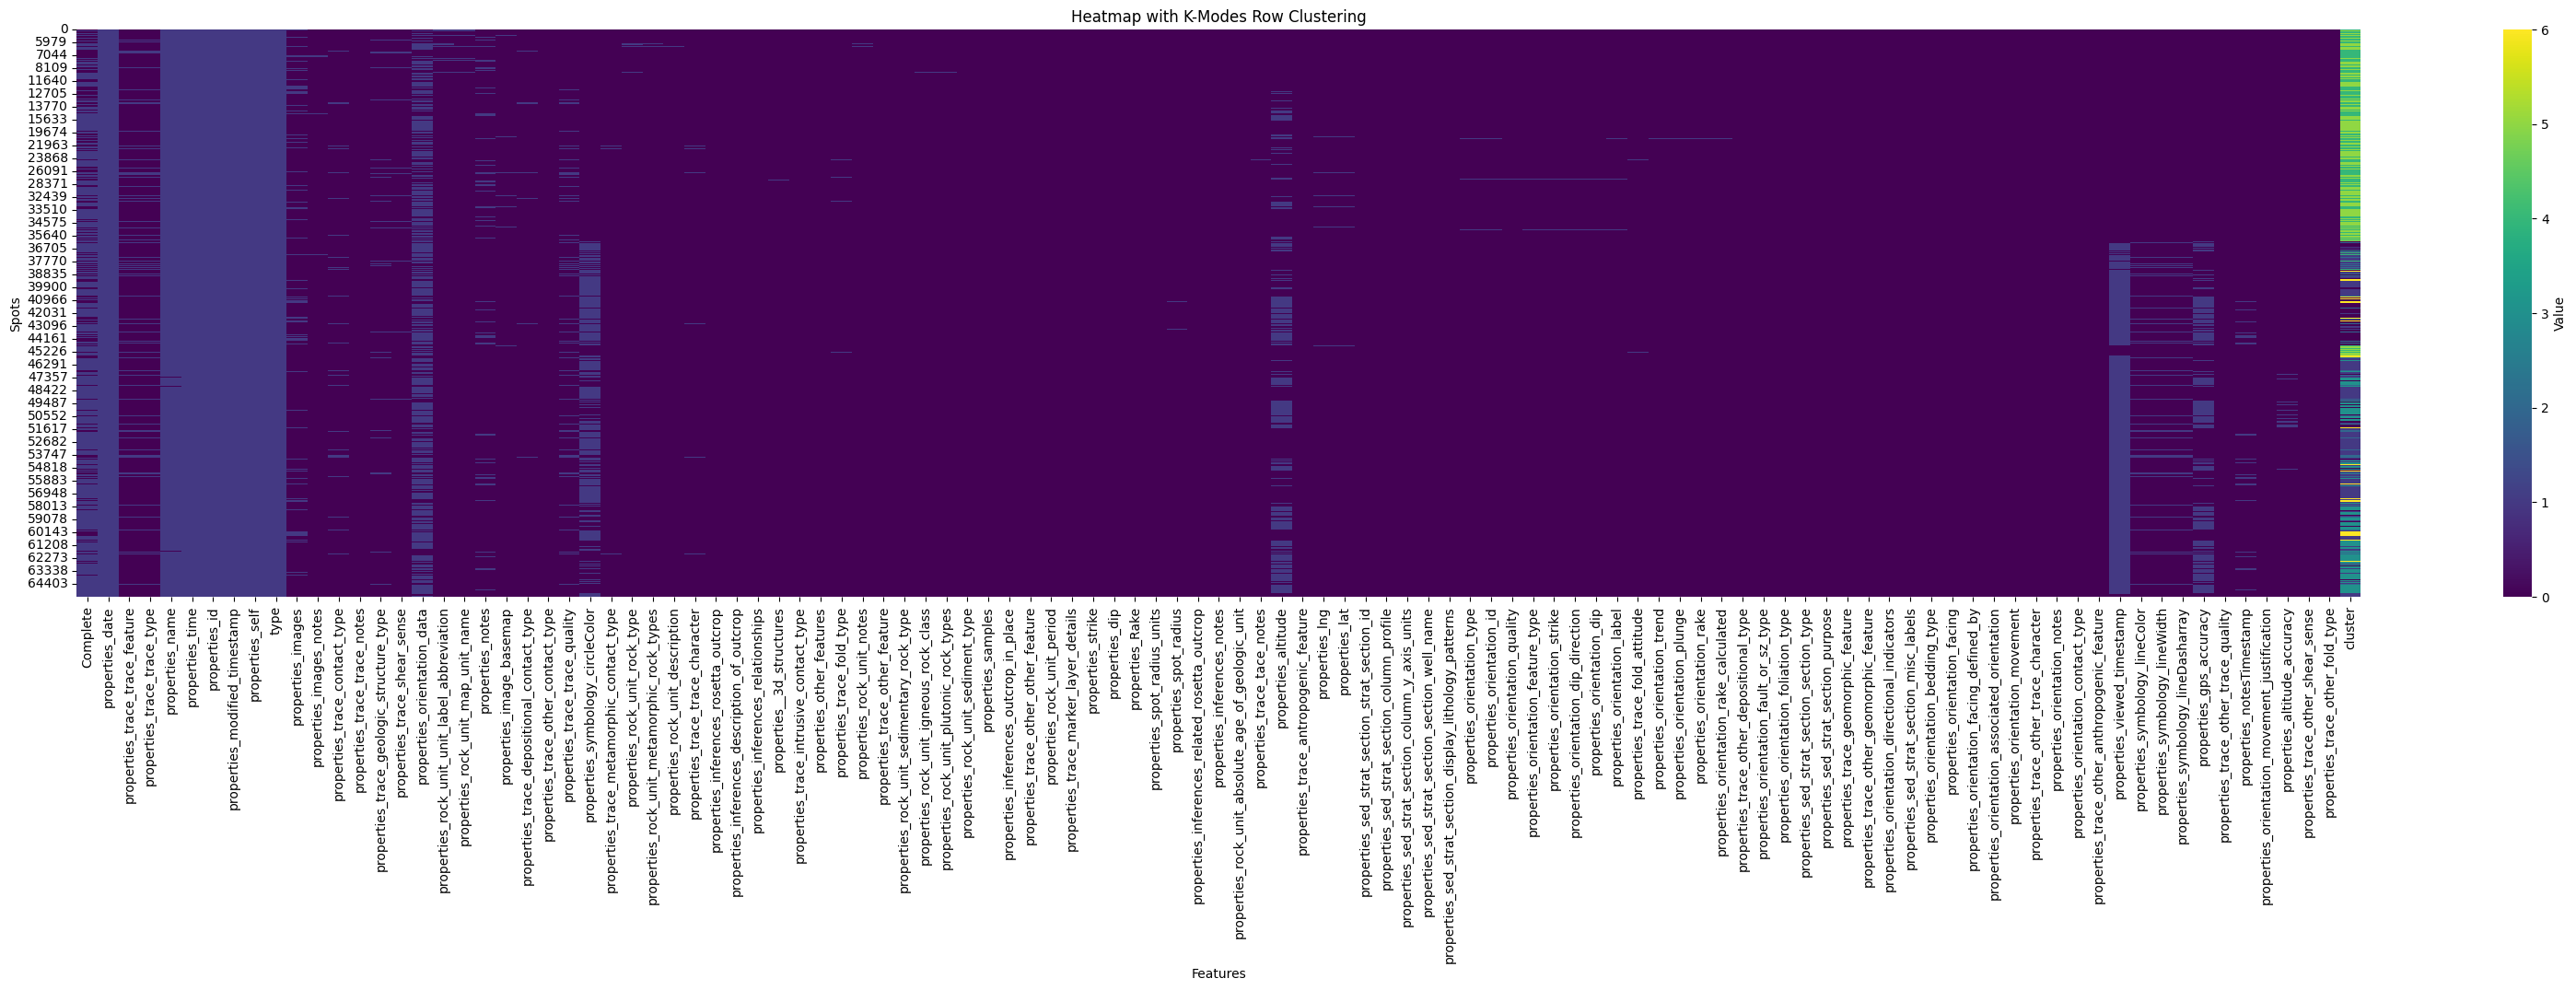

In [29]:
plt.figure(figsize=(40, 8))
sns.heatmap(df, cmap="viridis", cbar_kws={'label': 'Value'})
plt.title("Heatmap with K-Modes Row Clustering")
plt.ylabel("Spots")
plt.xlabel("Features")
plt.show()

In [30]:
val_count(df)

0
Complete
1.0    33997
0.0    12855
Name: count, dtype: int64
1
properties_date
1    46850
0        2
Name: count, dtype: int64
2
properties_trace_trace_feature
0    41863
1     4989
Name: count, dtype: int64
3
properties_trace_trace_type
0    41863
1     4989
Name: count, dtype: int64
4
properties_name
1    46623
0      229
Name: count, dtype: int64
5
properties_time
1    46850
0        2
Name: count, dtype: int64
6
properties_id
1    46850
0        2
Name: count, dtype: int64
7
properties_modified_timestamp
1    46850
0        2
Name: count, dtype: int64
8
properties_self
1    46850
0        2
Name: count, dtype: int64
9
type
1    46850
0        2
Name: count, dtype: int64
10
properties_images
0    41871
1     4981
Name: count, dtype: int64
11
properties_images_notes
0    46636
1      216
Name: count, dtype: int64
12
properties_trace_contact_type
0    44796
1     2056
Name: count, dtype: int64
13
properties_trace_trace_notes
0    46773
1       79
Name: count, dtype: int64
14
propert

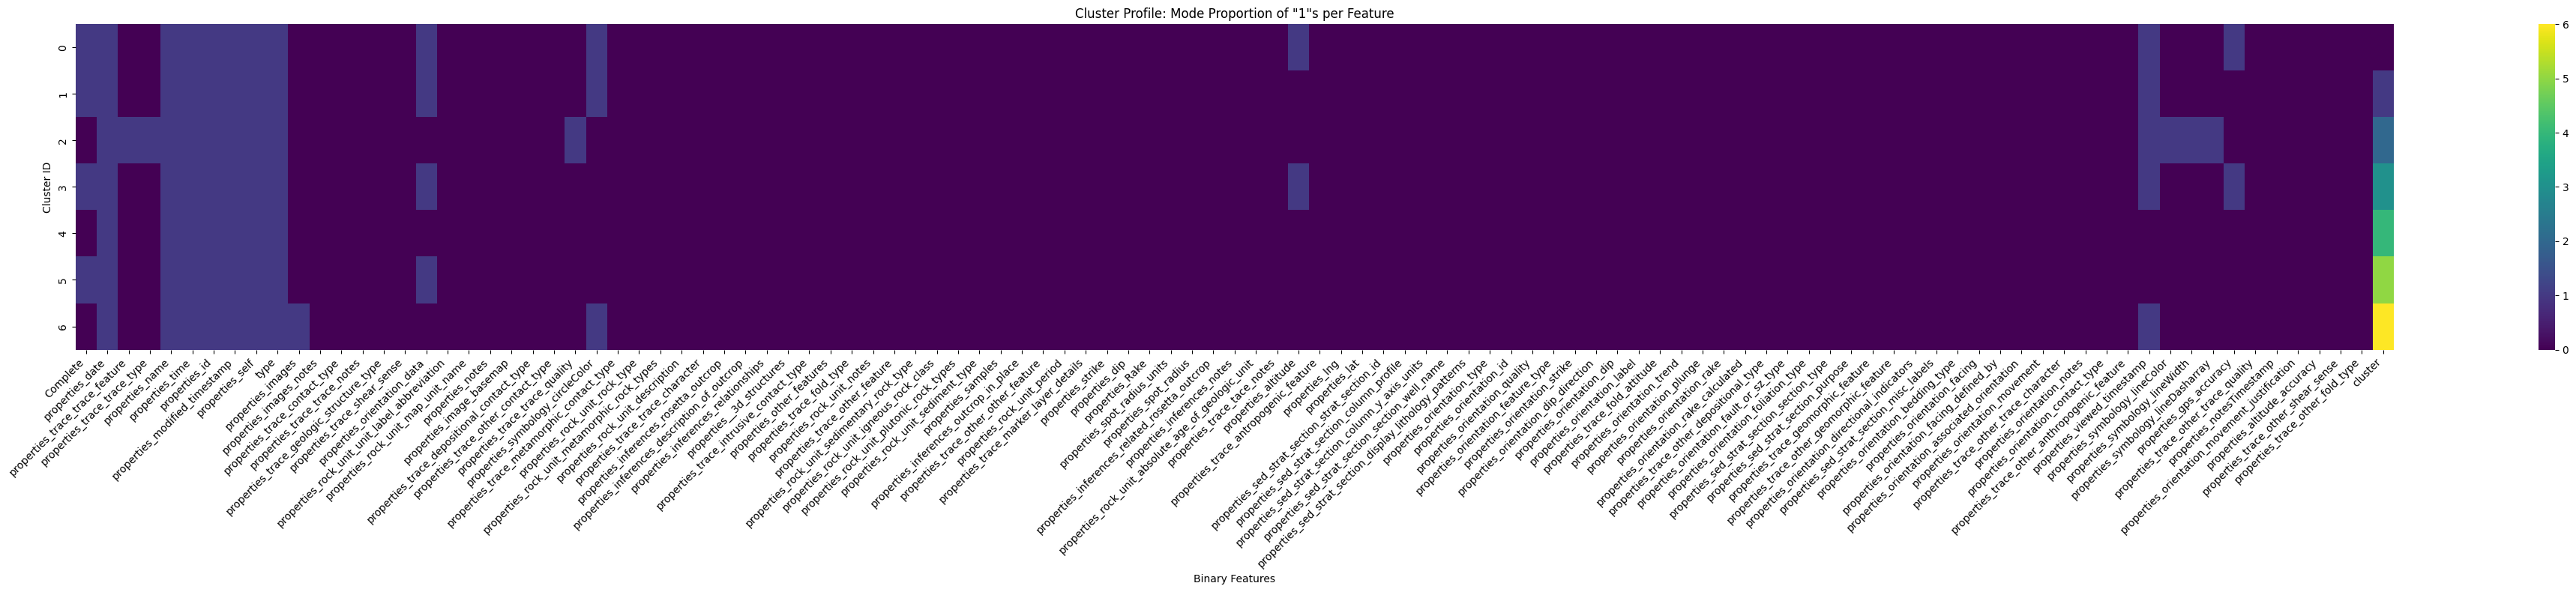

In [31]:
cluster_profile = df.groupby('cluster')[df.columns.to_list()].agg(pd.Series.mode)

plt.figure(figsize=(40, 8)) 
sns.heatmap(
    cluster_profile,
    annot=False,  # Set to False, takes forever to compile and you can't even read
    cmap='viridis' 
)
plt.title('Cluster Profile: Mode Proportion of "1"s per Feature')
plt.xlabel('Binary Features')
plt.ylabel('Cluster ID')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



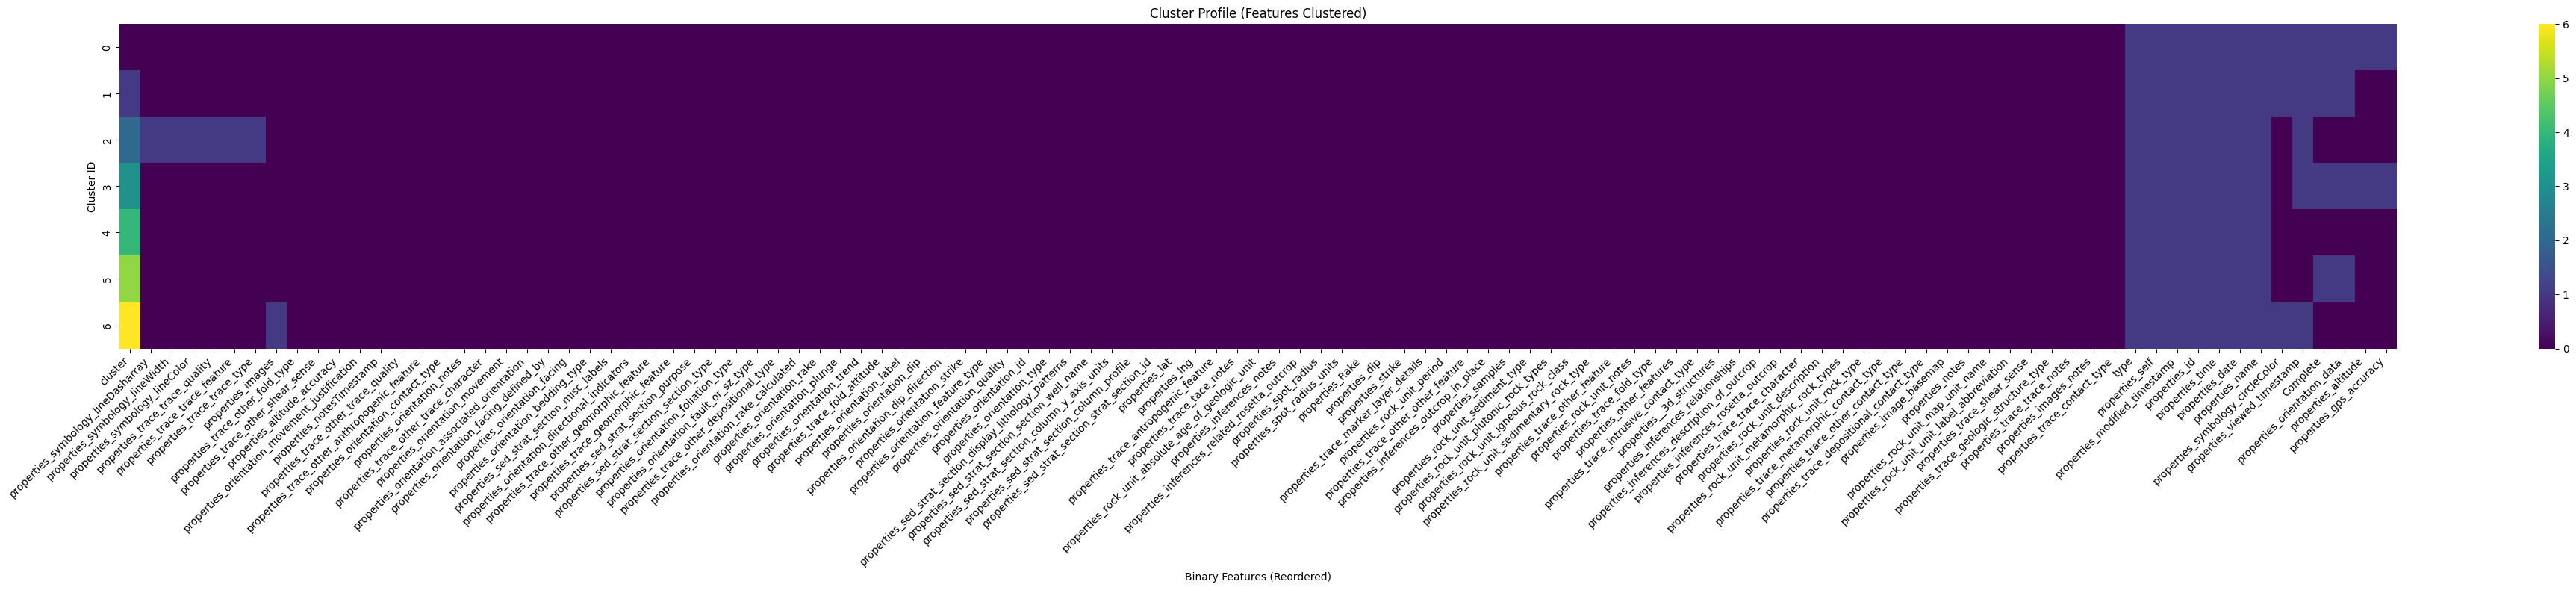

In [32]:
from scipy.cluster.hierarchy import linkage, leaves_list

Z = linkage(cluster_profile.T, method='ward', metric='euclidean')

feature_order = cluster_profile.columns[leaves_list(Z)]

ordered_profile = cluster_profile[feature_order]

plt.figure(figsize=(40, 8))
sns.heatmap(
    ordered_profile,
    cmap='viridis',
    annot=False
)
plt.title('Cluster Profile (Features Clustered)')
plt.xlabel('Binary Features (Reordered)')
plt.ylabel('Cluster ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
print(f"Silhouette Score: {silhouette_score(df.drop(columns= "cluster"), df["cluster"], metric= "hamming")}")

# print(f"Calinski Harabasz Score: {calinski_harabasz_score(df.drop(columns= "cluster"), df["cluster"])}")

Silhouette Score: 0.5139372556826789


In [34]:
for cluster in df["cluster"].unique():
    print(f"Cluster {cluster}: {len(df[df["cluster"] == cluster])} samples")
    val_count(df_copy[df_copy["cluster"] == cluster])

Cluster 4: 9428 samples
0
contacts drawing
b     2984
d     1710
c     1666
a-    1335
a      585
b-     409
b+     372
c-     289
c+      78
Name: count, dtype: int64
1
contacts drawing quality
d     2117
c     2106
b     1900
a-    1483
a      656
b+     500
b-     310
c-     273
c+      83
Name: count, dtype: int64
2
classification of spots
b     2332
c     2316
a     1091
a-     880
d      762
c-     716
b-     610
c+     375
b+     257
d+      89
Name: count, dtype: int64
3
correctness of spots
c     2819
b     2772
a     1197
d      910
a-     806
c-     301
b+     270
c+     265
b-      88
Name: count, dtype: int64
4
completeness of map
b     2683
c     2152
a     1562
a-    1021
c-     769
d      597
b+     356
b-     288
Name: count, dtype: int64
5
unit labels
a     3513
a-    1725
d     1342
c     1127
b      675
c-     326
b+     310
c+     274
b-      98
d+      38
Name: count, dtype: int64
6
images
b     2629
c     1793
a     1480
a-     929
b+     656
d      629
b-     48

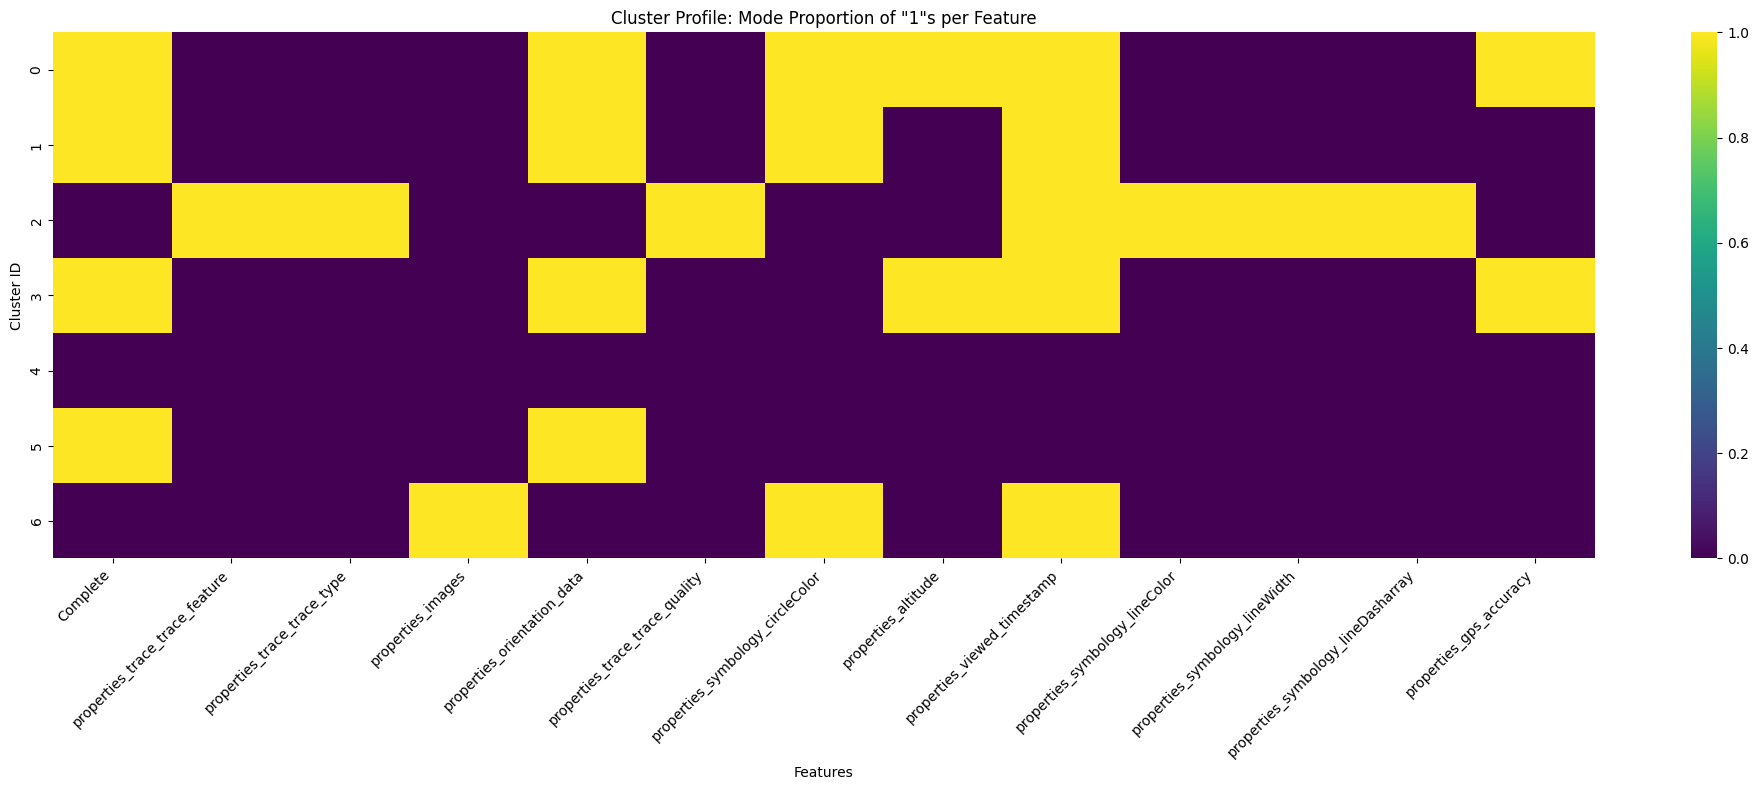

In [35]:
cluster_profile = df.groupby('cluster')[unique_modes_features].agg(pd.Series.mode)

plt.figure(figsize=(20, 8)) 
sns.heatmap(
    cluster_profile,
    annot=False,  # Set to False, takes forever to compile and you can't even read
    cmap='viridis' 
)
plt.title('Cluster Profile: Mode Proportion of "1"s per Feature')
plt.xlabel('Features')
plt.ylabel('Cluster ID')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

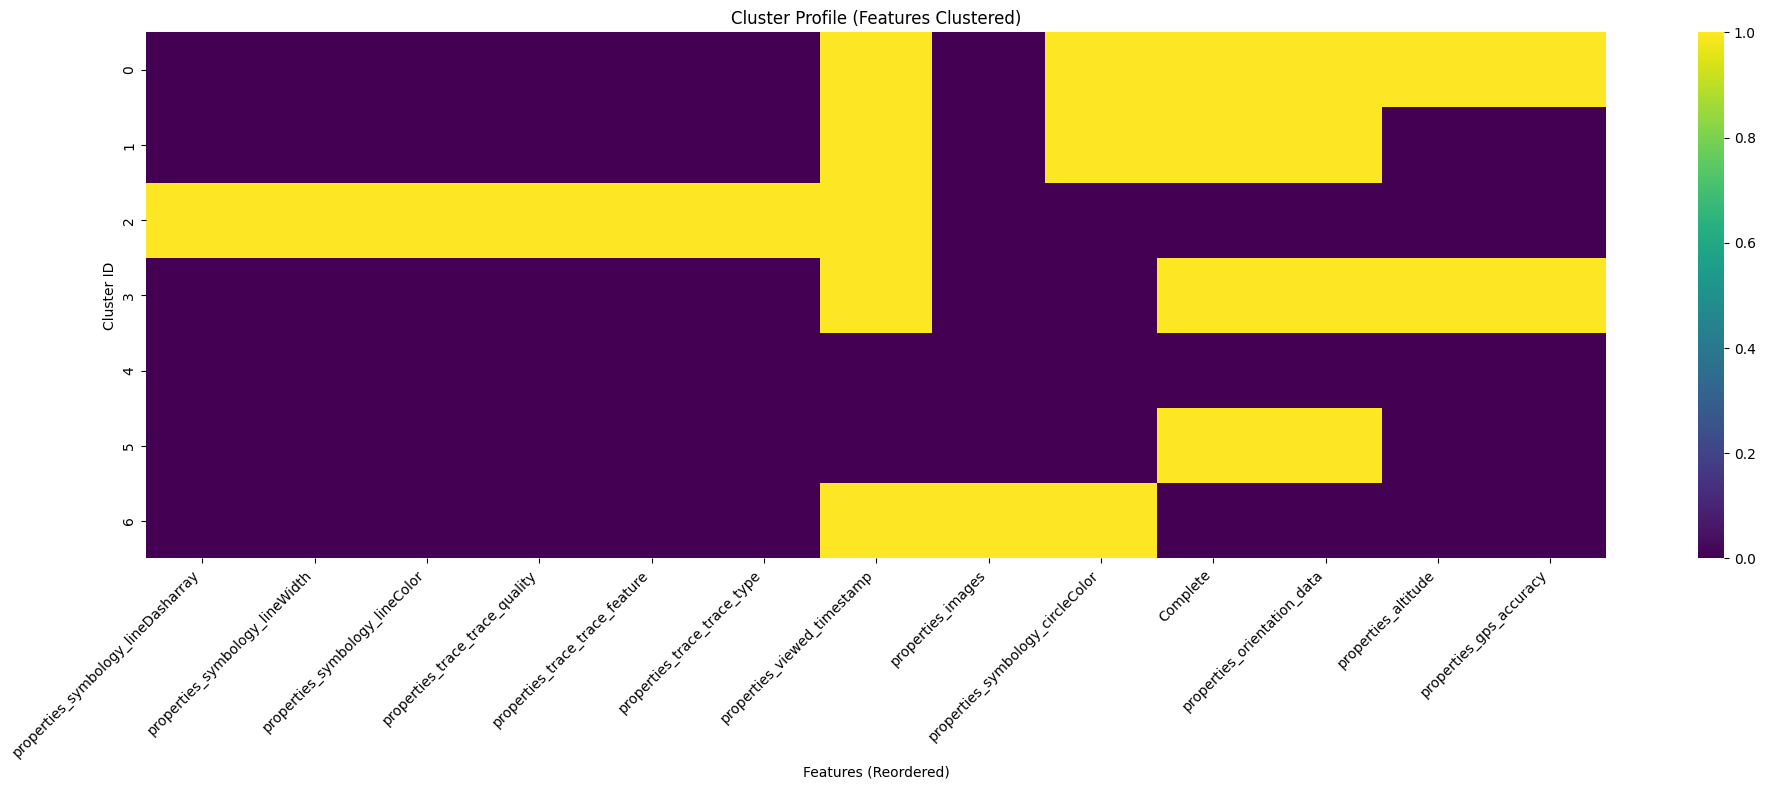

In [36]:
from scipy.cluster.hierarchy import linkage, leaves_list

Z = linkage(cluster_profile.T, method='ward', metric='euclidean')

feature_order = cluster_profile.columns[leaves_list(Z)]

ordered_profile = cluster_profile[feature_order]

plt.figure(figsize=(20, 8))
sns.heatmap(
    ordered_profile,
    cmap='viridis',
    annot=False
)
plt.title('Cluster Profile (Features Clustered)')
plt.xlabel('Features (Reordered)')
plt.ylabel('Cluster ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [37]:
selector = SelectKBest(f_classif, k=20)
selector.fit_transform(df[df.columns[:108]], df["cluster"])

cols_idxs = selector.get_support(indices=True)
df = df.iloc[:,cols_idxs]

val_count(df)


0
Complete
1.0    33997
0.0    12855
Name: count, dtype: int64
1
properties_trace_trace_feature
0    41863
1     4989
Name: count, dtype: int64
2
properties_trace_trace_type
0    41863
1     4989
Name: count, dtype: int64
3
properties_images
0    41871
1     4981
Name: count, dtype: int64
4
properties_trace_contact_type
0    44796
1     2056
Name: count, dtype: int64
5
properties_trace_geologic_structure_type
0    45133
1     1719
Name: count, dtype: int64
6
properties_trace_shear_sense
0    45902
1      950
Name: count, dtype: int64
7
properties_orientation_data
1    30717
0    16135
Name: count, dtype: int64
8
properties_trace_depositional_contact_type
0    46351
1      501
Name: count, dtype: int64
9
properties_trace_trace_quality
0    42299
1     4553
Name: count, dtype: int64
10
properties_symbology_circleColor
0    29195
1    17657
Name: count, dtype: int64
11
properties_altitude
0    30339
1    16513
Name: count, dtype: int64
12
properties_orientation_label
0    46210
1      642

In [38]:
print(len(set(df.columns).intersection(set(unique_modes_features))))

13
